In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from scipy.integrate import quad
import torch
import torch.nn as nndata
import torch.optim as optim
import os
import sys
# Add the current directory to Python path
sys.path.insert(0, os.path.abspath('.'))

# Now import from your local skfda
import skfda
from skfda import FDataBasis
from skfda.representation.basis import BSplineBasis, FourierBasis
from skfda.preprocessing.dim_reduction import FPCA

from models import *
from data_generation_new import *
from utils import *
from training import *

In [2]:
J = 5
d = 10000
sigma1 = np.repeat(1,J)
theta1 = np.diag(np.repeat(0.8,J))
X_coef,Z_coef = generate_ma1(J = J, d = d, sigma = sigma1, theta = theta1)
print(X_coef.shape)

(10000, 5)


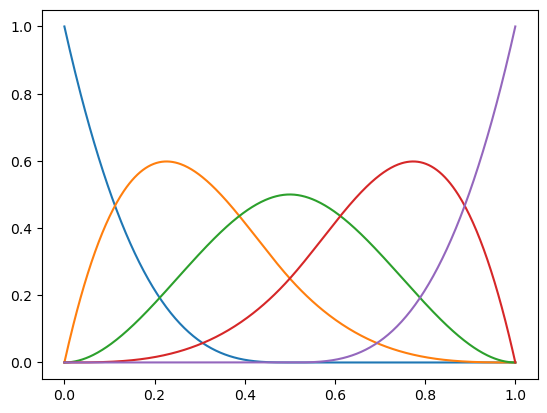

[0.26726124 0.33273756 0.3047247  0.33273756 0.26726124]


In [3]:
Bbasis = BSplineBasis(domain_range=(0, 1), n_basis=J)
Bbasis.plot()
plt.show()

G = Bbasis.gram_matrix()
norms = np.sqrt(np.diag(G))
print(norms)


So the bspline basis right now is not normalized, we times diag(1/n1,1/n2,....,1/nJ) to make it an normalized one.

$[b_1,b_2,\cdots,b_J]$ is the original bspline space.
$[\tilde{b}_1,\tilde{b}_2,\cdots,\tilde{b}_J] = diag(1/n1,1/n2,....,1/nJ) \times [b_1,b_2,\cdots,b_J]^T$ is the original bspline space.

In [4]:
from scipy.linalg import cholesky
G = Bbasis.gram_matrix()  # shape: (n_basis, n_basis)
L = cholesky(G, lower=True)
L_inv = np.linalg.inv(L)
X_orthonormal = X_coef @ L_inv.T
norm_values = np.sqrt(np.einsum("ij,jk,ik->i", X_orthonormal, G, X_orthonormal))
print(norm_values)

[1.85364805 1.97542856 3.05747217 ... 4.07107126 6.12642027 4.24994294]


In [5]:
X_unitnorm = X_orthonormal / norm_values[:, np.newaxis]
bspline_norm_basis = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_unitnorm  # X_coef: coefficient on 
)
# check if times diag(1/n1,1/n2,...,1/nJ), whether the norm would be all 1.
norm_values = np.sqrt(np.sum(bspline_norm_basis.coefficients @ G * bspline_norm_basis.coefficients, axis=1))

print(norm_values)

[1. 1. 1. ... 1. 1. 1.]


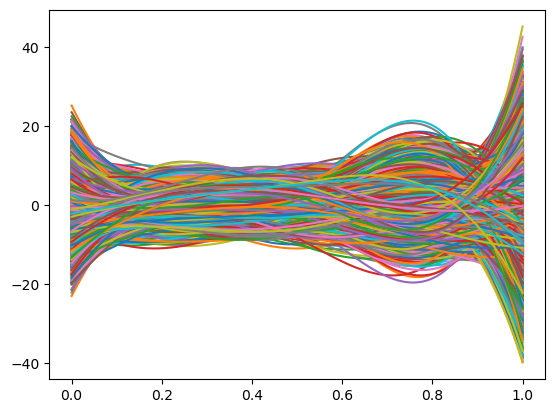

In [6]:
# Step 5: Construct functional object for FPCA
fd = FDataBasis(basis=Bbasis, coefficients=X_orthonormal)
fd.plot()
plt.show()


In [7]:
fpca = FPCA(n_components=5)
fpca.fit(fd)
scores = fpca.transform(fd)

# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
print(sum(fpca.explained_variance_ratio_))


Explained variance by each PC: [0.44555781 0.2359348  0.13990327 0.11516169 0.06344243]
1.0


In [8]:
print(scores)
print(scores.mean(axis=0))

[[-1.34708765  0.08289846  1.05137338  0.08491432  0.70077497]
 [-0.08942912  0.53602307  1.84997504  0.33271669 -0.28897251]
 [ 1.85762185 -2.28787755  0.73856549 -0.10576378 -0.48752113]
 ...
 [-2.51512165  1.03135054  2.82368533 -1.08465258  0.13320008]
 [-5.20637143 -1.61717512  2.38409881 -1.05495889  0.9139075 ]
 [-3.28564488  0.49363569  2.33215804 -0.89841773  0.85861179]]
[-2.05080397e-16  1.97225569e-16  5.13944443e-16  1.28608235e-16
  2.09499085e-16]


In [9]:
E_coef = fpca.components_.coefficients 


In [10]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: Bbasis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [11]:
Y_np.shape

(10000,)

In [12]:
X = torch.tensor(scores.T, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
print(Y.size())

torch.Size([5, 10000])
torch.Size([1, 10000])


# Model adding covariates

In [13]:
trunc_q = d-1 # the trunctation number
m = d**(1/7) # the bandwidth
print(m)
q = 4

3.72759372031494


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
/Users/xinyiwang/Desktop/Desktop - XINYI的MacBook Pro/UCDavis/research_alex/long-run-covariance/codes/models.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix[i, j] = torch.tensor(torch.sum(weighted_cross_cov), dtype=X.dtype, device=X.device)
/Users/xinyiwang/Desktop/Desktop - XINYI的MacBook Pro/UCDavis/research_alex/long-run-covariance/codes/models.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Epoch [200/10000], Loss: 1.5183
Epoch [400/10000], Loss: 1.4158
Epoch [600/10000], Loss: 1.2743
Epoch [800/10000], Loss: 1.0922
Epoch [1000/10000], Loss: 0.8690
Epoch [1200/10000], Loss: 0.6215
Epoch [1400/10000], Loss: 0.3899
Epoch [1600/10000], Loss: 0.2151
Epoch [1800/10000], Loss: 0.1076
Epoch [2000/10000], Loss: 0.0508
Epoch [2200/10000], Loss: 0.0232
Epoch [2400/10000], Loss: 0.0104
Epoch [2600/10000], Loss: 0.0046
Epoch [2800/10000], Loss: 0.0020
Epoch [3000/10000], Loss: 0.0008
Epoch [3200/10000], Loss: 0.0003
Epoch [3400/10000], Loss: 0.0001
Stopping early at Epoch [3442/10000], Loss: 0.000100

Restoring best model and weight network...


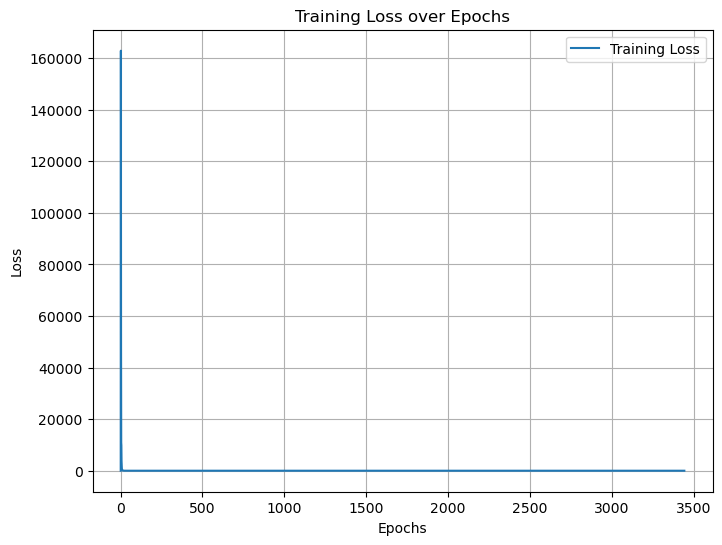

In [14]:
trained_model, trained_weight_net, learned_weights = train_model(X, Y, Weight_QS, Model1_new, LR_cov_X, m, q, trunc_q)


Shape of Covariance Matrix (NumPy): (5, 5)


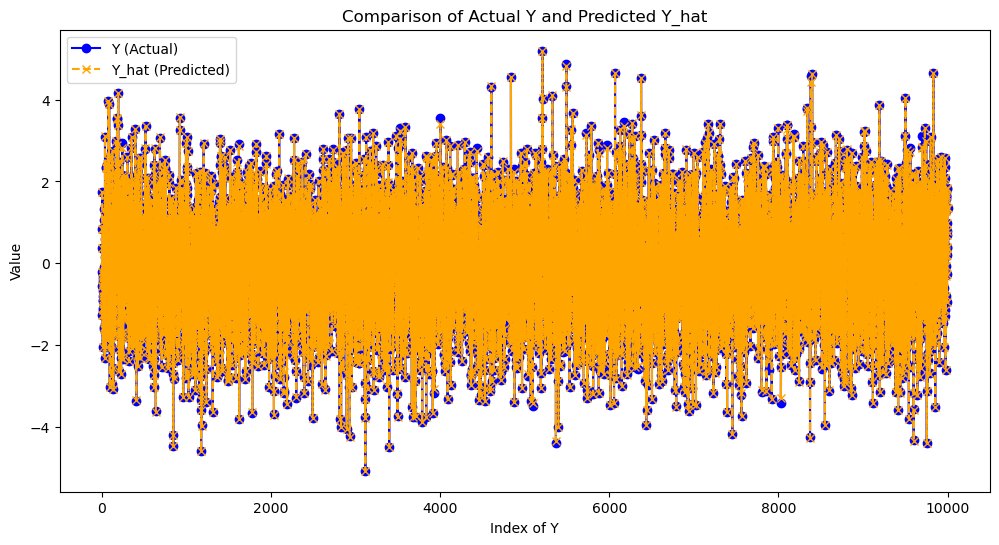

In [15]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_matrix, cov_matrix_w1, cov_matrix3 = LR_cov_X(X, trained_weight_net, trunc_q)
    cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


In [16]:
cov_matrix

tensor([[ 6.0432e+00, -2.1535e-02,  1.7187e-03,  2.2242e-02,  1.1425e-03],
        [ 4.8417e-02,  3.1817e+00,  8.8321e-03,  1.3088e-02,  3.6232e-02],
        [ 3.9836e-02, -2.2293e-02,  1.9088e+00,  3.5648e-03, -1.4367e-02],
        [-4.7176e-03, -1.5153e-02,  2.6058e-03,  1.5575e+00,  1.9531e-03],
        [-1.0425e-02, -6.9205e-03,  6.7822e-03,  1.5312e-02,  8.7150e-01]])

In [17]:
import os
import pandas as pd
# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, f"cov_matrix_case1_FMA_{d}.csv")

# Convert matrices to DataFrames
df1 = pd.DataFrame(cov_matrix)
df2 = pd.DataFrame(cov_matrix_w1)
df3 = pd.DataFrame(cov_matrix3)

# Save matrices to CSV with an empty line between them
with open(csv_path, 'w', newline='') as f:
    df1.to_csv(f, index=False, header=False)
    f.write("\n")  # Write an empty line
    df2.to_csv(f, index=False, header=False)
    f.write("\n")  # Write another empty line
    df3.to_csv(f, index=False, header=False)

print(f"Saved matrices to {csv_path} with empty lines between them.")

Saved matrices to results/cov_matrix_case1_FMA_10000.csv with empty lines between them.


# Compute true covariance matrix

In [18]:
theoretical_cov_true = np.diag([3.24] * 5)

print(theoretical_cov_true)

[[3.24 0.   0.   0.   0.  ]
 [0.   3.24 0.   0.   0.  ]
 [0.   0.   3.24 0.   0.  ]
 [0.   0.   0.   3.24 0.  ]
 [0.   0.   0.   0.   3.24]]


In [19]:
sum(np.diag(theoretical_cov_true))

np.float64(16.200000000000003)

In [20]:
cov_matrix_np= cov_matrix.detach().cpu().numpy()
sum(np.diag(cov_matrix_np))

np.float32(13.562733)

In [21]:
E_coef = fpca.components_.coefficients.T

In [22]:
hat_C = np.zeros((5, 5))

for l in range(5):
    for lp in range(5):
        sum1 = np.sum([E_coef[l, k] * G[:, k] for k in range(5)], axis=0)
        sum2 = np.sum([E_coef[lp, k] * G[:, k] for k in range(5)], axis=0)
        hat_C[l, lp] = np.sum([theoretical_cov_true[i, j] * sum1[i] * sum2[j] for i in range(5) for j in range(5)])
#print(np.round(hat_C,4))

In [23]:
np.trace(hat_C)

np.float64(6.4332311353054115)

In [24]:
print(np.linalg.eigvals(hat_C))
sum(np.linalg.eigvals(hat_C))

[4.88161869e+00 1.18604034e+00 3.29401196e-01 3.34976773e-02
 2.67323462e-03]


np.float64(6.4332311353054115)

In [25]:
np.round(hat_C,4)

array([[ 1.7815, -0.8565,  1.6854, -0.6629,  0.7612],
       [-0.8565,  0.8165, -1.0074,  0.4545, -0.0885],
       [ 1.6854, -1.0074,  1.8478, -0.8438,  0.9557],
       [-0.6629,  0.4545, -0.8438,  0.5129, -0.6161],
       [ 0.7612, -0.0885,  0.9557, -0.6161,  1.4745]])

In [26]:
cov_matrix

tensor([[ 6.0432e+00, -2.1535e-02,  1.7187e-03,  2.2242e-02,  1.1425e-03],
        [ 4.8417e-02,  3.1817e+00,  8.8321e-03,  1.3088e-02,  3.6232e-02],
        [ 3.9836e-02, -2.2293e-02,  1.9088e+00,  3.5648e-03, -1.4367e-02],
        [-4.7176e-03, -1.5153e-02,  2.6058e-03,  1.5575e+00,  1.9531e-03],
        [-1.0425e-02, -6.9205e-03,  6.7822e-03,  1.5312e-02,  8.7150e-01]])

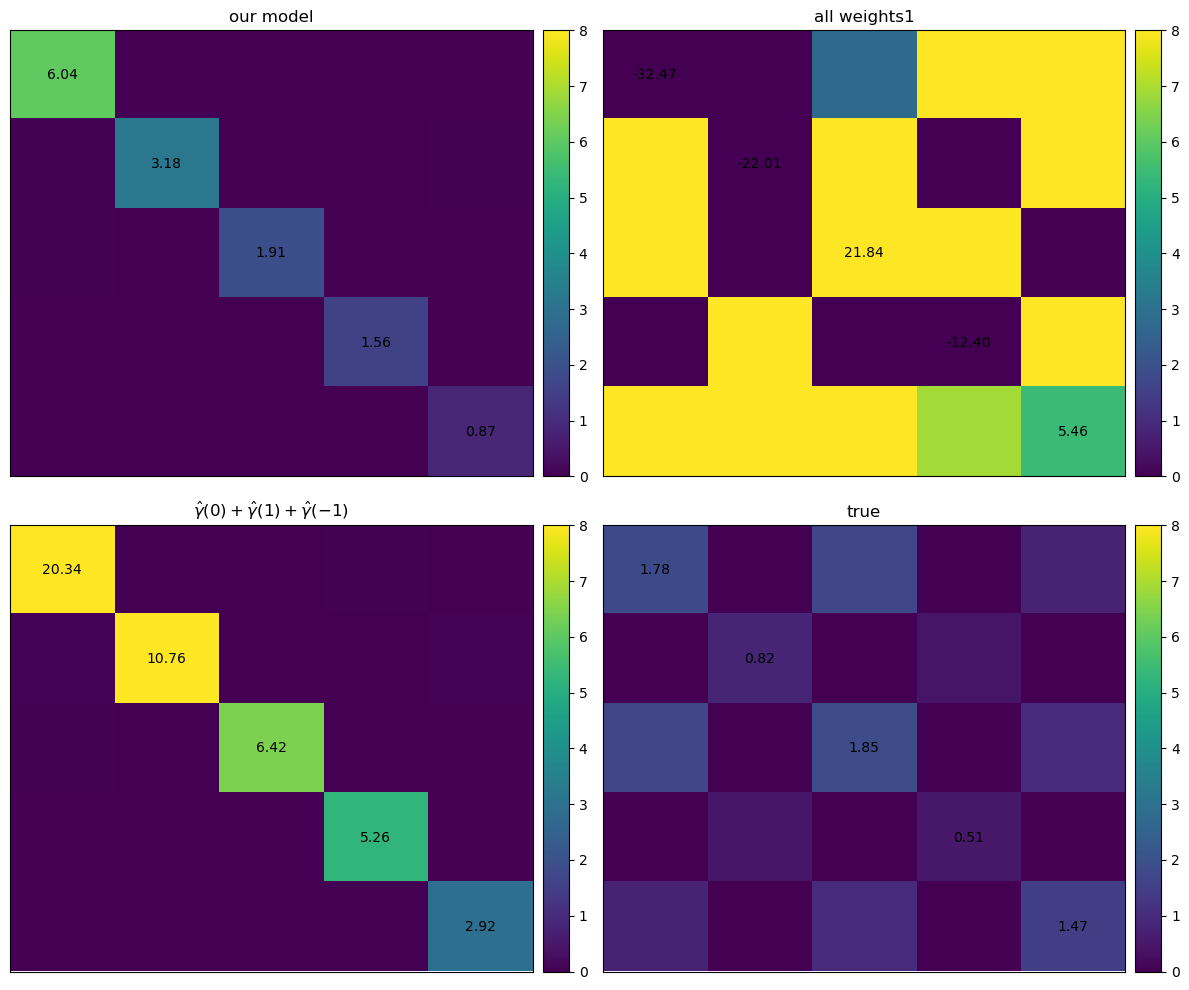

In [27]:
fig = plot_matrices_2d([cov_matrix,cov_matrix_w1, cov_matrix3, hat_C], titles = ["our model", "all weights1", r"$\hat{\gamma}(0) + \hat{\gamma}(1) + \hat{\gamma}(-1)$", "true"])

In [28]:
filename = f"figures/matrix3d_compare{d}_truc{trunc_q}_bd{round(m)}_q{q}.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free memory

print(f"Plot saved as {filename}")

Plot saved as figures/matrix3d_compare10000_truc9999_bd4_q4.png


In [29]:
print("Sum of diagonal (cov_matrix):", torch.trace(cov_matrix))
print("Sum of diagonal (cov_matrix_w1):", torch.trace(cov_matrix_w1))
print("Sum of diagonal (cov_matrix3):", torch.trace(cov_matrix3))
print("Sum of diagonal (hat_C):", np.trace(hat_C))

Sum of diagonal (cov_matrix): tensor(13.5627)
Sum of diagonal (cov_matrix_w1): tensor(-39.5721)
Sum of diagonal (cov_matrix3): tensor(45.6976)
Sum of diagonal (hat_C): 6.4332311353054115


In [30]:
n = cov_matrix.shape[0]
delta = 1.0 / n

# Compute squared error via Riemann sum
L_T_h = np.sum((cov_matrix.detach().cpu().numpy() - hat_C) ** 2) * (delta ** 2)

print("L_{T,h} =", L_T_h)

L_{T,h} = 1.6338920825062757
